In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# import the regressors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# import metrics
from sklearn.metrics import mean_squared_error

# Import the dataset

In [4]:
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Analyzing the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


## Fixing Datatype

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


<ipython-input-6-87651bb8c13d>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


## Checking Duplicated Value

In [7]:
df[df.duplicated()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


## Fixing Outliers

In [8]:
def find_outlier_rows(df, col, level='both'):
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]

In [9]:
def count_outliers(df):
    df_numeric = df.select_dtypes(include=['int', 'float'])

    columns = df_numeric.columns

    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]
    
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        outliers_df.loc[col] = [outlier_count, outlier_percent]

    return outliers_df

## Count of the outliers in the columns of the sales dataframe

In [10]:
count_outliers(df).sort_values('outlier_counts', ascending=False)

,outlier_counts,outlier_percent
Unemployment,481.0,7.47
Holiday_Flag,450.0,6.99
Weekly_Sales,34.0,0.53
Temperature,3.0,0.05


The above dataframe shows that weekly_sales, holiday_flag, temperature and unemployment columns all have outliers with unemployment having the largest outlier percentage, 7%. Let’s examine the outliers in each column to decide on how to handle them.

In [11]:
find_outlier_rows(df, 'Unemployment')['Unemployment'].describe()

count    481.000000
mean      11.447480
std        3.891387
min        3.879000
25%       11.627000
50%       13.503000
75%       14.021000
max       14.313000
Name: Unemployment, dtype: float64

The minimum and maximum values of these outliers are 3.88% and 14.31% respectively. Majority, greater or equal to 75%, are more than or equal to 11.6% These values are obtainable in reality and will be left intact for the analysis. Thus, median, which rubust to outliers, will be used to measure the centre of the unemployment rate distribution.

In [12]:
find_outlier_rows(df, 'Holiday_Flag')['Holiday_Flag'].describe()

count    450.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Holiday_Flag, dtype: float64

We can see that all special holiday weeks form the outliers. This is as a result of the fact that most of the weeks, 93%, are non-special holiday weeks. This will also be left intact.

In [13]:
find_outlier_rows(df, 'Weekly_Sales')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
189,2,2010-12-24,3436007.68,0,49.97,2.886,211.064660,8.163
241,2,2011-12-23,3224369.80,0,46.66,3.112,218.999550,7.441
471,4,2010-11-26,2789469.45,1,48.08,2.752,126.669267,7.127
474,4,2010-12-17,2740057.14,0,46.57,2.884,126.879484,7.127
475,4,2010-12-24,3526713.39,0,43.21,2.887,126.983581,7.127
523,4,2011-11-25,3004702.33,1,47.96,3.225,129.836400,5.143
526,4,2011-12-16,2771397.17,0,36.44,3.149,129.898065,5.143
527,4,2011-12-23,3676388.98,0,35.92,3.103,129.984548,5.143
761,6,2010-12-24,2727575.18,0,55.07,2.886,212.916508,7.007
1329,10,2010-11-26,2939946.38,1,55.33,3.162,126.669267,9.003


We can note that all the weekly_sales outliers occur either in November or December with one outlier of the outliers that occur in October.

**Does the dataset require any feature engineering to better support the analysis goals?**

Employment rate may be correlated with weekly sales. This will be created from the unemployment rate. Also the date column will be split into three so that we can analyse the data by year, month or day.

In [14]:
df['Employment'] = 100 - df['Unemployment']
df.sample(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment
608,5,2010-10-15,280681.20,0,68.11,2.720,212.369187,6.768,93.232
1179,9,2010-08-10,505069.21,0,65.35,2.633,215.290437,6.560,93.440
1866,14,2010-03-26,2050396.27,0,54.36,2.854,181.971870,8.992,91.008


In [15]:
# split the date column
df['Year']= df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment,Year,Month,Day
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,91.894,2010,5,2
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,91.894,2010,12,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,91.894,2010,2,19


# Exploratory Data Analysis

In [16]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Employment,Year,Month,Day
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,92.000849,2010.965035,6.475524,15.650350
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.875885,0.797019,3.321797,8.753908
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,85.687000,2010.000000,1.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,91.378000,2010.000000,4.000000,8.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,92.126000,2011.000000,6.000000,16.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,93.109000,2012.000000,9.000000,23.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,96.121000,2012.000000,12.000000,31.000000


## Analyzing Distribution

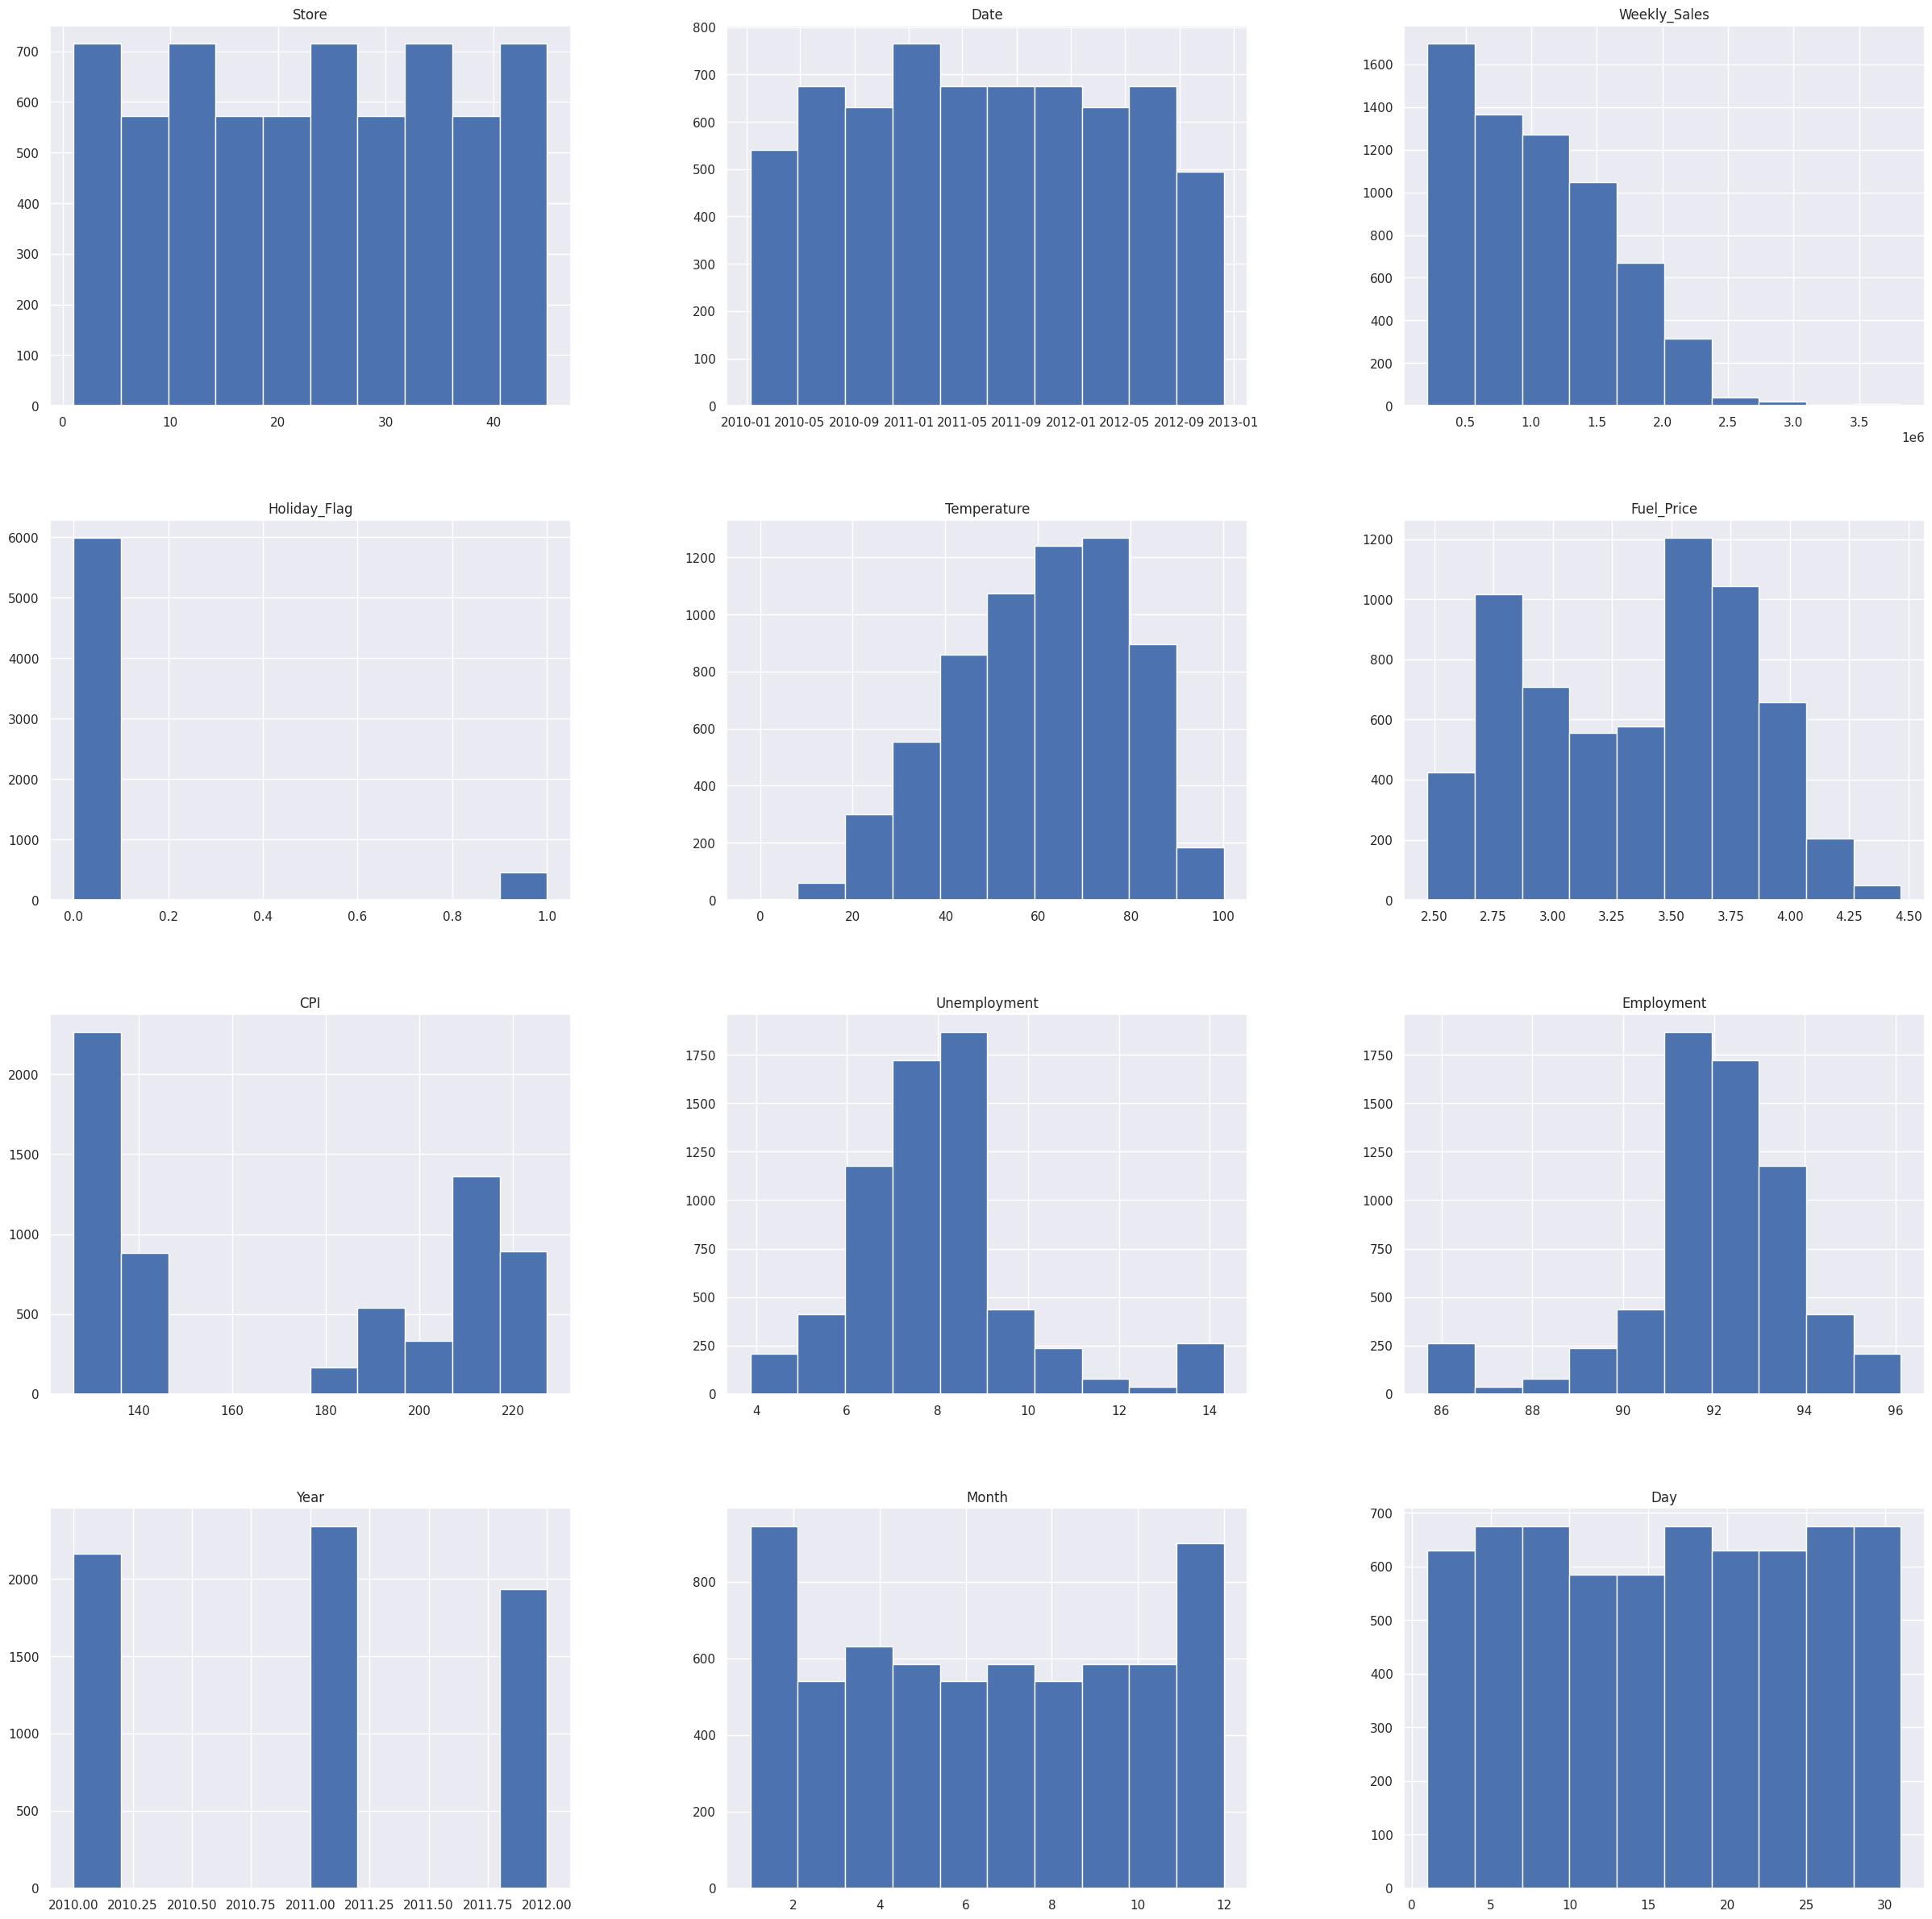

In [17]:
df.hist(figsize=(30,30))
plt.show()


From the above histograms, we can understand that:

1. The number of transactions occurred almost evenly across various stores and years.
2. The distribution of weekly_sales right-skewed. Only a few of the weekly sales are above 2 million USD.
3. The distribution of temperature is approximately normal.
4. The distribution of fuel_price is bi-modal.
5. CPI formed two clusters.
6. Unemployment rate is near normally distributed.
7. Four consecutive months November-February recorded the highest sales.

## What is the overall trend in sales over time?

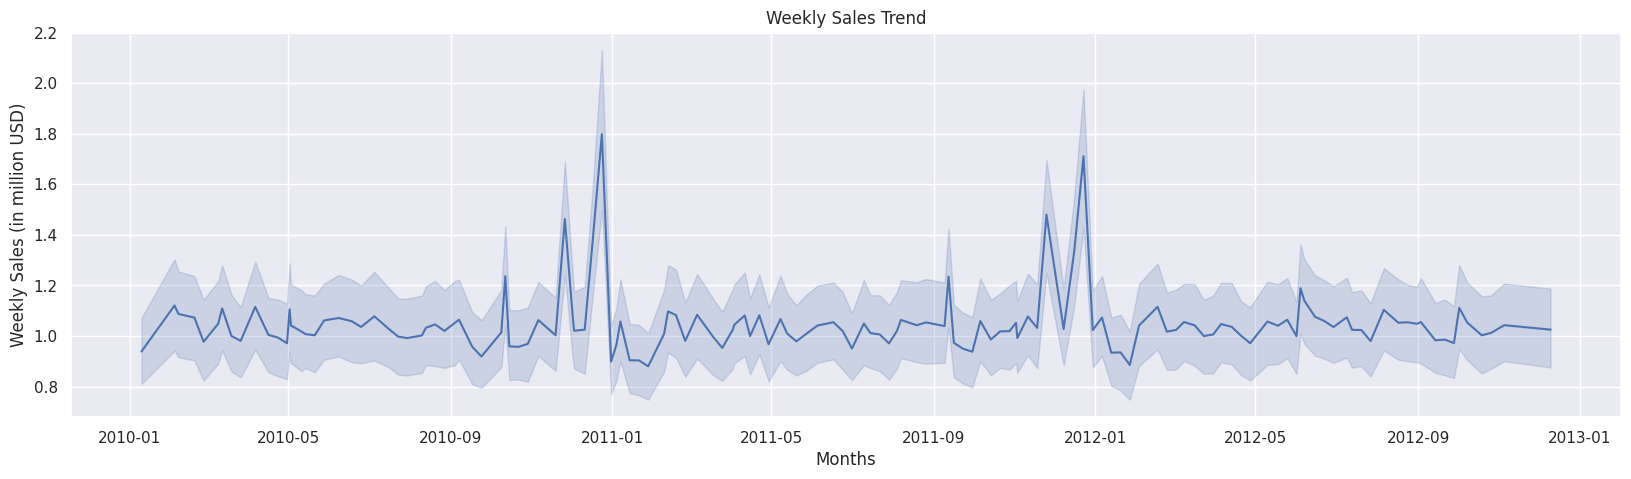

In [18]:
plt.figure(figsize=(20,5))

sns.lineplot(x=df.Date, y=(df.Weekly_Sales/1e6))

plt.xlabel('Months')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Weekly Sales Trend')


plt.show()

## Are there any seasonality trends in the dataset?

In [19]:
pivot_table = df.pivot_table(index='Month', columns='Year', values='Weekly_Sales')
pivot_table

Year,2010,2011,2012
Month,,,
1,9.386639e+05,9.420697e+05,9.567817e+05
2,1.064372e+06,1.042273e+06,1.057997e+06
3,1.034590e+06,1.011263e+06,1.025510e+06
4,1.021177e+06,1.033220e+06,1.014127e+06
5,1.039303e+06,1.015565e+06,1.053948e+06
6,1.055082e+06,1.038471e+06,1.082920e+06
7,1.023702e+06,9.976049e+05,1.025480e+06
8,1.025212e+06,1.044895e+06,1.064514e+06
9,9.983559e+05,1.026810e+06,9.988663e+05


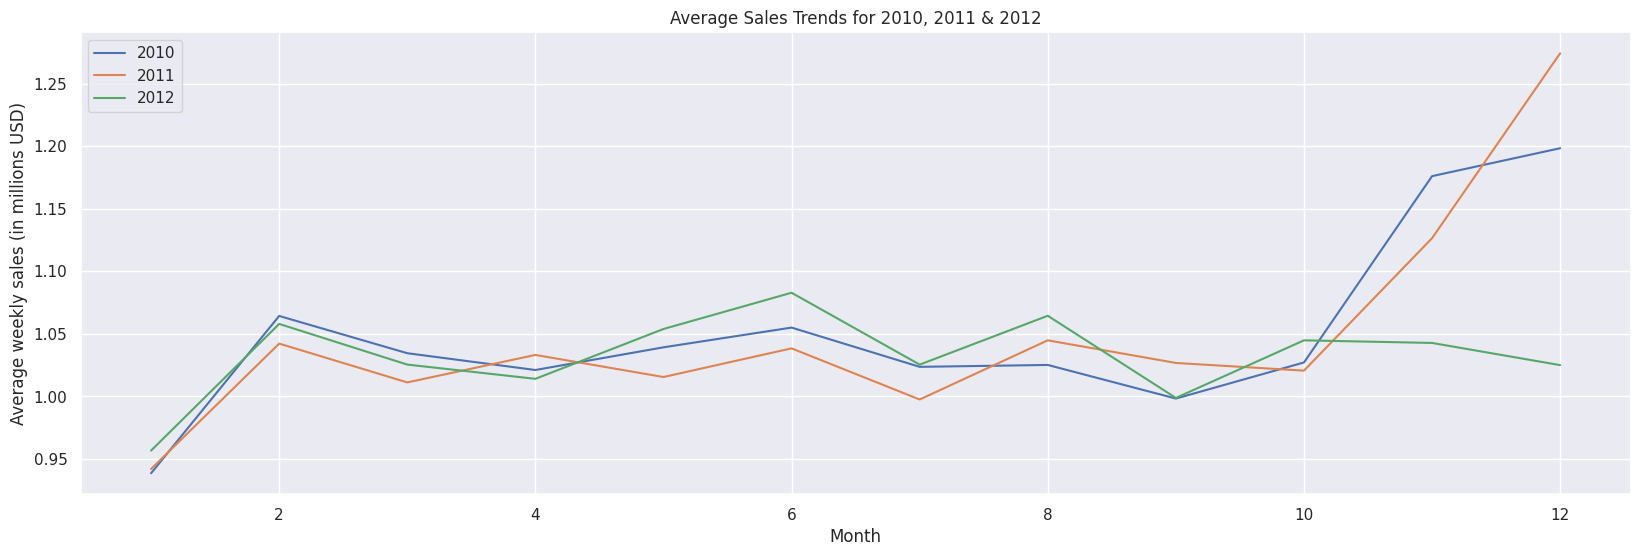

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(x=pivot_table.index, y=pivot_table[2010]/1e6, ax=ax, label='2010')
sns.lineplot( x=pivot_table.index, y=pivot_table[2011]/1e6, ax=ax, label='2011')
sns.lineplot( x=pivot_table.index, y=pivot_table[2012]/1e6, ax=ax, label='2012')

plt.ylabel('Average weekly sales (in millions USD)')
plt.title('Average Sales Trends for 2010, 2011 & 2012')

plt.legend()
plt.show()

## Which stores had the highest and lowest average revenues over the years?

In [38]:
sales_store = df.groupby('Store').sum().reset_index()
top_sales_store = sales_store.sort_values('Weekly_Sales',ascending=False).head()[['Store','Weekly_Sales']]
top_sales_store

<ipython-input-38-91d0fef9fc30>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_store = df.groupby('Store').sum().reset_index()


,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08


In [22]:
bottom_sales_store = sales_store.sort_values('Weekly_Sales',ascending=True).head()[['Store','Weekly_Sales']]
bottom_sales_store

,Store,Weekly_Sales
32,33,37160221.96
43,44,43293087.84
4,5,45475688.90
35,36,53412214.97
37,38,55159626.42


<Axes: xlabel='Store', ylabel='Weekly_Sales'>

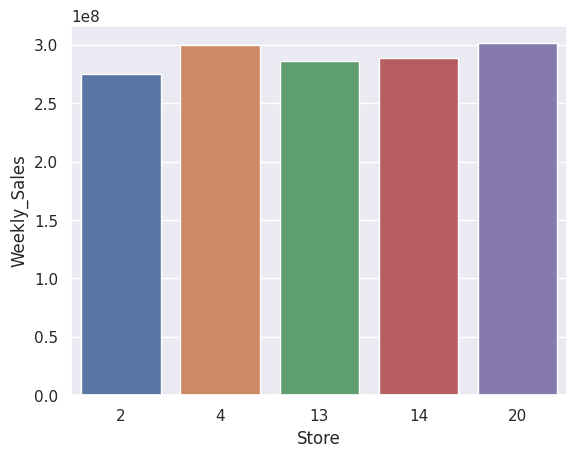

In [23]:
sns.barplot(x='Store',y='Weekly_Sales',data=top_sales_store)

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

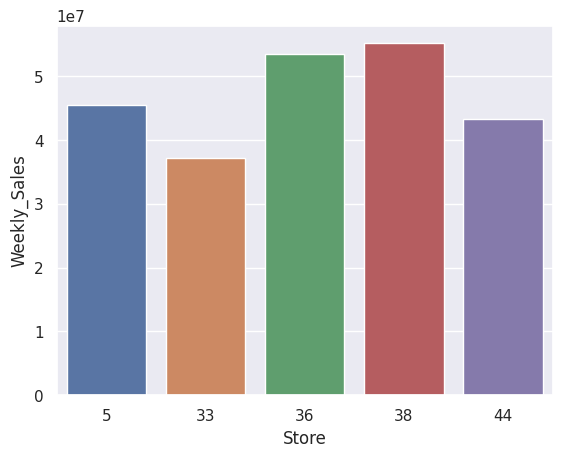

In [24]:
sns.barplot(x='Store',y='Weekly_Sales',data=bottom_sales_store)

## Which stores had the highest and lowest average revenues over the years?

In [25]:
# filter out non-holiday and holiday weekly sales 
non_holiday_sales = df[df['Holiday_Flag'] == 0]
holiday_sales = df[df['Holiday_Flag'] == 1]

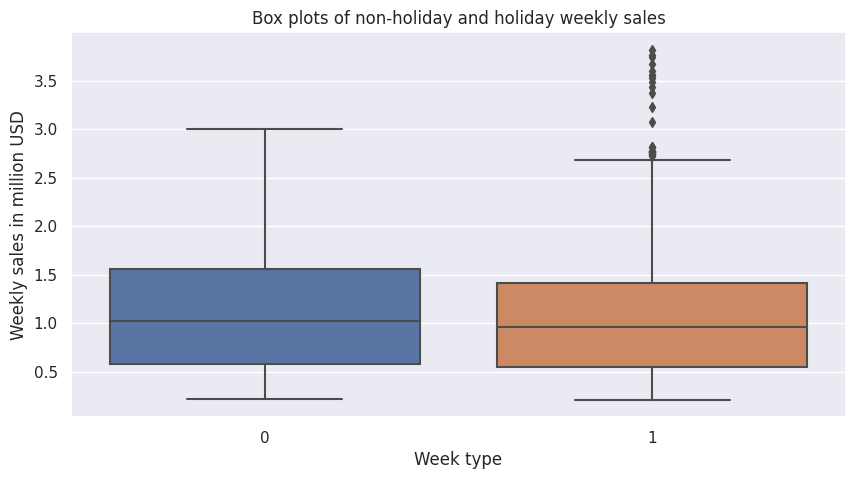

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=[holiday_sales['Weekly_Sales']/1e6, non_holiday_sales['Weekly_Sales']/1e6])
plt.ylabel('Weekly sales in million USD')
plt.xlabel('Week type')
plt.title('Box plots of non-holiday and holiday weekly sales')
plt.show()

We can see that both holiday and non-holiday weekly sales have similar spread. However, the bigger sales happen during the holiday weeks.

## Are there correlations between the features of the dataset and weekly_sales?

<ipython-input-27-f39f3d3dd816>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")


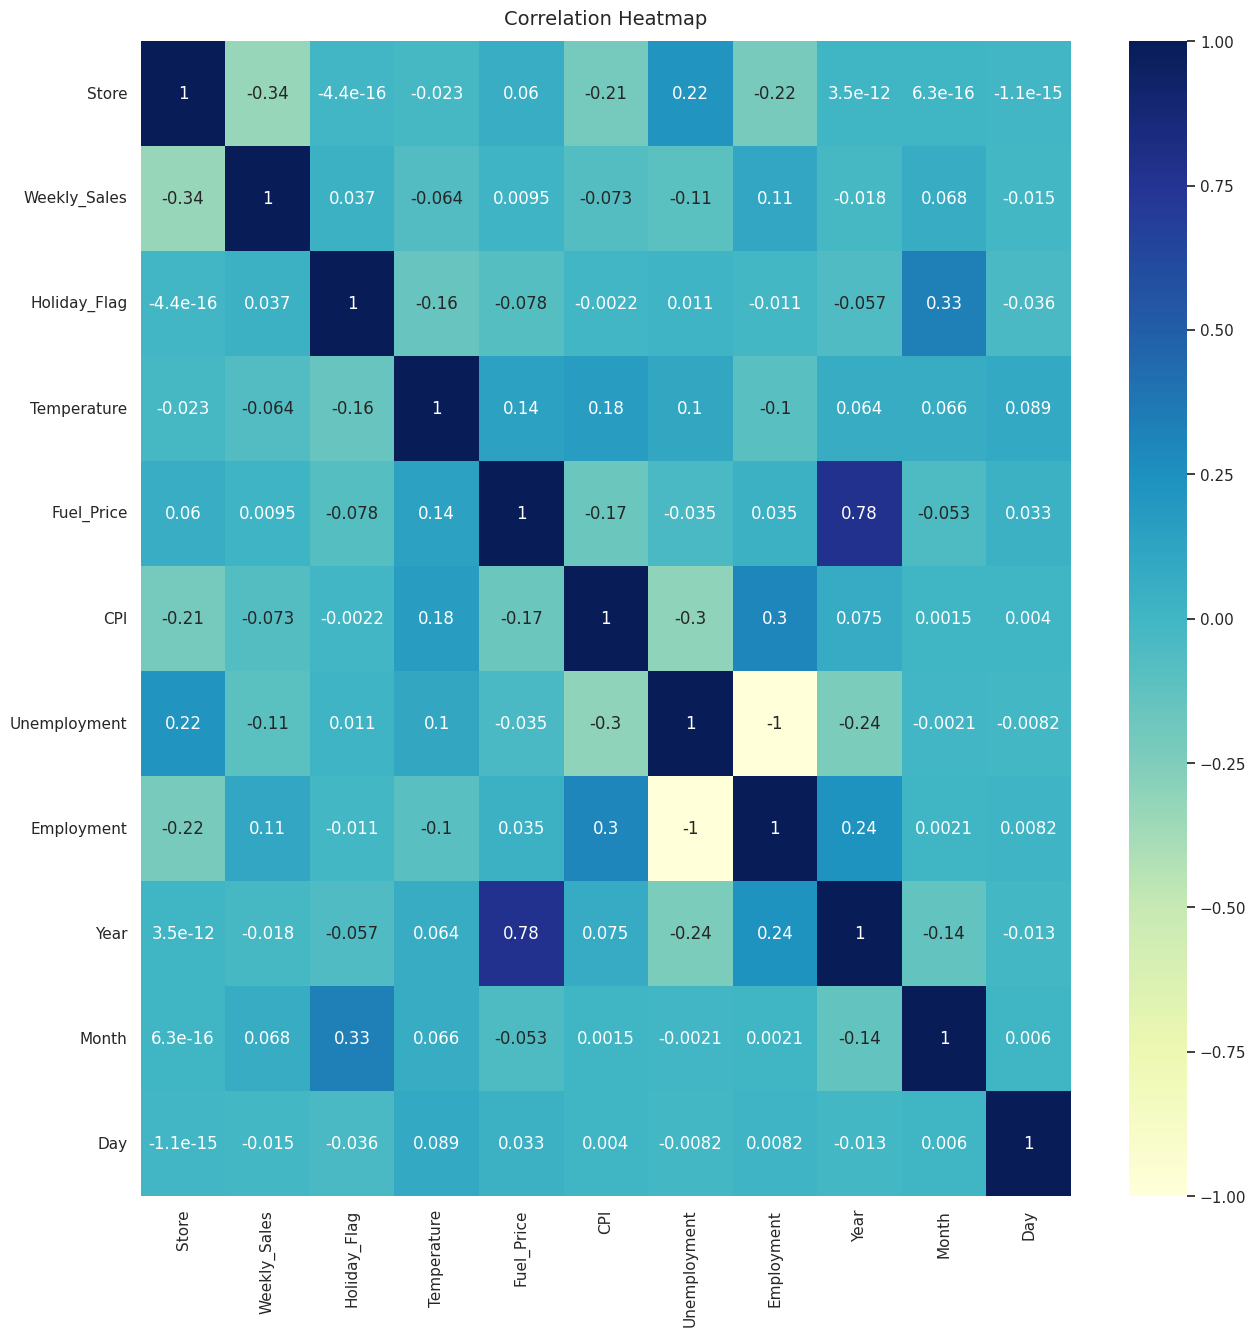

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

Of all the weaker correlations, employment is the strongest with 0.11 correlation coefficient.

# Model Building

In [28]:
df_copy = df.copy()

## Dropping Unnecesary Columns

In [29]:
df_copy.drop(['Date', 'Unemployment'], axis=1, inplace=True)
df_copy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Employment,Year,Month,Day
0,1,1643690.90,0,42.31,2.572,211.096358,91.894,2010,5,2
1,1,1641957.44,1,38.51,2.548,211.242170,91.894,2010,12,2
2,1,1611968.17,0,39.93,2.514,211.289143,91.894,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,91.894,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,91.894,2010,5,3


## Separating X and y

In [30]:
X = df_copy.drop('Weekly_Sales', axis=1)
y = df_copy['Weekly_Sales']

## Scaling the features

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

## Splitting Train and Test Data

In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

## Model Training

In [33]:
def evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test):
    rmses = [evaluate_model(regressor, X_train, y_train, X_test, y_test) for regressor in regressors]
    regressor_rmses = dict(zip(regressor_names, rmses))
    df = pd.DataFrame.from_dict(regressor_rmses, orient='index')
    df = df.reset_index()
    df.columns = ['regressor_name', 'rmse']
    return df.sort_values('rmse', ignore_index=True)

In [34]:
linear_regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree=2)
polynomial_regressor = Pipeline([("polynomial_features", polynomial_features),
("linear_regression", linear_regressor)])
decision_tree_regressor = DecisionTreeRegressor()
random_forest_regressor = RandomForestRegressor()
support_vector_regressor = SVR()
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='uniform')

In [35]:
# collect the list of regressors
regressors = [linear_regressor, polynomial_regressor,decision_tree_regressor, random_forest_regressor,  
              support_vector_regressor, knn_regressor]

# collect the names of regressors
regressor_names = ["Linear Regression", "Polynomial Regression", "Decision Tree Regression", "Random Forest Regression", "Support Vector Regression","K-Nearest Neighbour Regression"]

In [36]:
print('\033[1m Table of regressors and their RMSEs')
evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)

 Table of regressors and their RMSEs


,regressor_name,rmse
0,Random Forest Regression,118696.710206
1,Decision Tree Regression,149962.029074
2,K-Nearest Neighbour Regression,460652.064212
3,Polynomial Regression,478647.893015
4,Linear Regression,520962.802146
5,Support Vector Regression,568799.580050


In [37]:
rmse = evaluate_regressors_rmses(regressors, regressor_names, X_train, y_train, X_test, y_test)

best_rmse = rmse.iloc[0]['rmse']
median_sale = df['Weekly_Sales'].median()
percent_deviation = round((best_rmse*100/median_sale), 2)

# print the result
print('The model has average percentage error of {}%'.format(percent_deviation))

The model has average percentage error of 12.09%


# Conclusions
Our analysis shows that sales during holiday weeks are significantly higher than during non-holiday weeks, with sales doubling on average. Additionally, there is a strong seasonal component to the sales data. The average sales of the top performing stores are up to 500% higher than the lowest performing stores.

The best model for predicting future sales is the Random Forest Regressor model,which achieved an RMSE of 1.18e+05. This is a good estimate as it is 88% close to the median sale of the data.

These findings have important implications for businesses as they can inform decisions about inventory, staffing, and marketing efforts. By understanding the factors that drive sales and using a reliable model to forecast future sales, businesses can better plan for the future and optimize their resources.